In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import scipy as sp
import networkx as nx
import collections
import time
import math
import cProfile

Execution time benchmark (Old version of code)

5 nodes = 2.172417640686035 seconds

10 nodes = 3.4716975688934326 seconds

50 nodes = 29.19156312942505 seconds

100 nodes = 91.34214448928833 seconds

200 nodes = 334.28435039520264 seconds

500 nodes = 1918.9069437980652 seconds

1000 nodes = 7633.156857967377 seconds

2000 nodes = 29493.039113521576 seconds

5000 nodes = 179618.58132219315 seconds

In [2]:
def neighbor_nodes(graph, num_nodes):
    
    neighbor_dict = {key : [] for key in range(num_nodes)}
    
    # Checking each row and col that has an edge (element = 1)
    for row, col in zip(*graph.nonzero()):
        neighbor_dict[row].append(col)
        
    return neighbor_dict

In [3]:
def output_update(path, output_matrix):
    pair = [(path[i], path[i + 1]) for i in range(len(path)-1)]
    for i in pair:
        output_matrix[i[0], i[1]] = 1
        output_matrix[i[1], i[0]] = 1
    return output_matrix

In [21]:
## Fastest

def sample_spanning_tree(A):
    # Step 0: function setup
    num_nodes = A.shape[0]
    mat_A = A.todense()
    unvisited_node = set(range(num_nodes))
    walk_hist = np.empty(0, dtype= np.int32)
    is_connected = False
    output_init = sp.sparse.lil_matrix((num_nodes, num_nodes), dtype = np.int32)
    neighbor_dict = neighbor_nodes(A, num_nodes)
    
    # Step 1: random the start and terminal node
    start_node = random.choice(tuple(unvisited_node))
    unvisited_node.remove(start_node)
    terminal_node = random.choice(tuple(unvisited_node))
    walk_hist = np.append(walk_hist, start_node)
    #print((start_node, terminal_node))
    #unvisited_node.remove(terminal_node)
    current_node = start_node
    
    # Step 2: perform Loop-erased Random walk and get the main path (T1 = LE(W1))
    while terminal_node in unvisited_node: # until first path is complete
        feasible_nodes = neighbor_dict[current_node] # randomly pick the neighbor node
        next_node = random.choice(feasible_nodes)
        current_node = next_node
        walk_hist = np.append(walk_hist, current_node) # This is W1
        if current_node in unvisited_node:
            unvisited_node.remove(current_node)
        else: # this creates a loop
            # update the walk_hist, insert the looped node back to unvisited_node and reset to where it starts
            index = np.where(walk_hist == current_node)[0][0]
            unvisited_node = unvisited_node.union(set(walk_hist[index+1:-1]))
            walk_hist = walk_hist[:index+1]
    visited_node = set(walk_hist)
    #print("walk_hist = ", walk_hist)
    output = output_update(walk_hist, output_init)
    # if a spanning tree is created in this step, skip step 3
    if len(unvisited_node) == 0:
        is_connected = True
    #print("unvisited_node = ", unvisited_node)
    
    # Step 3: initiate a new unvisited node and perform LERW until it joins some node of T1
    new_walk_hist = np.empty(0, dtype= np.int32)
    while len(unvisited_node) != 0 or is_connected == False:      
        if len(new_walk_hist) == 0:
            new_start_node = random.choice(tuple(unvisited_node))
            new_walk_hist = np.append(new_walk_hist, new_start_node)
            unvisited_node.remove(new_start_node)
            new_current_node = new_start_node
        #print(new_current_node)
        feasible_nodes = neighbor_dict[current_node]
        new_next_node = random.choice(feasible_nodes)
        #print(new_next_node)
        new_current_node = new_next_node
        new_walk_hist = np.append(new_walk_hist, new_current_node)
        if new_current_node in unvisited_node:
            unvisited_node.remove(new_current_node)
        elif new_current_node in visited_node: # it hits some node in T_i
            is_connected = True # in the second-round walk, it definitely confirms hitting some node in T1
            visited_node = visited_node.union(set(new_walk_hist))
            # update the output into sparse matrix
            output = output_update(new_walk_hist, output)
            new_walk_hist = np.empty(0, dtype="int32") # clear all history and restart the process 
        else: # this creates a loop
            # update the walk_hist, insert the looped node back to unvisited_node and reset to where it starts
            index = np.where(new_walk_hist == new_current_node)[0][0]
            unvisited_node = unvisited_node.union(set(new_walk_hist[index+1:-1]))
            new_walk_hist = new_walk_hist[:index+1]           
            
    return output # sparse matrix of a spanning tree

In [105]:
def degree_freq_cdf(g, n):
    '''To calculate the degree of all vertices of a tree, take a look at the CDF of the degrees, aggregating over all
    randomly-generated spanning trees'''
    cdf_mat = []
    #deg_feq = []
    
    # Generate n spanning tree from the original graph, g.
    for _ in range(n):
        sample_tree = sample_spanning_tree(g)
    
        # For each tree, compute degrees and sort them.
        sorted_deg = sorted([sample_tree.sum(axis = 1)[i,0] for i in range(sample_tree.shape[0])]) # sum in each row
        unique_deg = set(sorted_deg)
        # Collect the frequency of each degree
        deg_counter = {deg : 0 for deg in list(unique_deg)}
        for i in sorted_deg:
            deg_counter[i] = deg_counter.get(i,0) + 1

        # Look at how PMF and CDF of the degrees looks, collect all degree CDF from individual spanning tree.
        pmf_dict = {}

        for i in range(1, max(deg_counter)+1):
            pmf_dict[i] = round(deg_counter.get(i, 0)/len(sorted_deg), 3) # If there's no specific num of node, use zero.
        pmf = list(pmf_dict.values())
        cdf = np.cumsum(pmf)
        cdf_mat.append(cdf)

    return cdf_mat, sorted_deg

In [136]:
def max_deg_plot(graph, ntrees, nreps, nnodes = None):
    start = time.time()
    if nnodes != None: # in case of no observed graph, generate complete graph instead
        graph = nx.to_scipy_sparse_matrix(nx.complete_graph(nnodes))
        print("Running for n = ", nnodes)
    max_deg_dict = {}
    std_list = []
    max_deg_list = []
    for i in range(nreps):
        deg_list = degree_freq_cdf(graph, ntrees)[1] # 100 replicated spanning trees
        max_deg = max(deg_list)
        max_deg_list.append(max_deg)
        print("Completed running #", i+1, "replicate(s)")
    avg = np.average(max_deg_list)
    std = np.std(max_deg_list)
    max_deg_dict[nnodes] = (avg,std)
    #std = np.std(list(max_deg_dict.values())) #/ np.sqrt(len(list(max_deg_dict.values())))
    #std_list.append(std)
    end = time.time()
    print("Total execution time for", graph.shape[0], "nodes = ", end-start, " seconds")
    return max_deg_dict

In [110]:
g5 = nx.to_scipy_sparse_matrix(nx.complete_graph(5))

In [111]:
g10 = nx.to_scipy_sparse_matrix(nx.complete_graph(10))

In [112]:
g50 = nx.to_scipy_sparse_matrix(nx.complete_graph(50))

In [113]:
g100 = nx.to_scipy_sparse_matrix(nx.complete_graph(100))

In [114]:
g200 = nx.to_scipy_sparse_matrix(nx.complete_graph(200))

In [115]:
g500 = nx.to_scipy_sparse_matrix(nx.complete_graph(500))

In [116]:
g1000 = nx.to_scipy_sparse_matrix(nx.complete_graph(1000))

In [118]:
g2000 = nx.to_scipy_sparse_matrix(nx.complete_graph(2000))

In [117]:
g5000 = nx.to_scipy_sparse_matrix(nx.complete_graph(5000))

In [30]:
test2_spanning_tree = sample_spanning_tree_mock(test2)

In [22]:
# Using lil_matrix is more efficient
start = time.time()
test_spanning_tree = sample_spanning_tree_mock(test)
end = time.time()
print(test_spanning_tree)
print(end-start, "secs")

  (0, 4181)	1
  (0, 4419)	1
  (0, 4422)	1
  (1, 530)	1
  (1, 1260)	1
  (1, 4168)	1
  (2, 4373)	1
  (3, 4944)	1
  (4, 2316)	1
  (4, 4630)	1
  (5, 3442)	1
  (6, 2902)	1
  (6, 4585)	1
  (7, 1475)	1
  (7, 3076)	1
  (8, 1310)	1
  (8, 1683)	1
  (9, 2174)	1
  (10, 817)	1
  (11, 634)	1
  (11, 4658)	1
  (12, 1719)	1
  (12, 4317)	1
  (12, 4800)	1
  (13, 1273)	1
  (13, 3065)	1
  (14, 1571)	1
  (14, 4636)	1
  (15, 3041)	1
  (15, 4078)	1
  (16, 1789)	1
  (17, 1158)	1
  (17, 1278)	1
  (17, 3565)	1
  (17, 4400)	1
  (18, 182)	1
  (18, 2564)	1
  (18, 4704)	1
  (19, 4009)	1
  (19, 4657)	1
  (20, 4108)	1
  (21, 2411)	1
  (22, 2745)	1
  (22, 4749)	1
  (23, 3919)	1
  (23, 4953)	1
  (24, 372)	1
  (25, 2306)	1
  (25, 4424)	1
  (26, 2335)	1
  (26, 3522)	1
  (27, 1128)	1
  (28, 1728)	1
  (28, 2384)	1
  (28, 3806)	1
  (29, 865)	1
  (29, 3628)	1
  (30, 413)	1
  (30, 2855)	1
  (30, 2891)	1
  (30, 4642)	1
  (31, 1478)	1
  (32, 1921)	1
  (32, 4006)	1
  (32, 4243)	1
  (33, 2206)	1
  (34, 225)	1
  (35, 679)	1
  (35, 

In [74]:
start = time.time()
test_deg_freq_cdf = degree_freq_cdf(test, 100)
end = time.time()
print(end-start, "secs")

870.8934433460236 secs


In [107]:
start = time.time()
test_max_deg_plot = max_deg_plot(test50, 100, 50)
end = time.time()
print(end-start, "secs")

Completed running # 1 replicate(s)
Completed running # 2 replicate(s)
Completed running # 3 replicate(s)
Completed running # 4 replicate(s)
Completed running # 5 replicate(s)
Completed running # 6 replicate(s)
Completed running # 7 replicate(s)
Completed running # 8 replicate(s)
Completed running # 9 replicate(s)
Completed running # 10 replicate(s)
Completed running # 11 replicate(s)
Completed running # 12 replicate(s)
Completed running # 13 replicate(s)
Completed running # 14 replicate(s)
Completed running # 15 replicate(s)
Completed running # 16 replicate(s)
Completed running # 17 replicate(s)
Completed running # 18 replicate(s)
Completed running # 19 replicate(s)
Completed running # 20 replicate(s)
Completed running # 21 replicate(s)
Completed running # 22 replicate(s)
Completed running # 23 replicate(s)
Completed running # 24 replicate(s)
Completed running # 25 replicate(s)
Completed running # 26 replicate(s)
Completed running # 27 replicate(s)
Completed running # 28 replicate(s)
C

### Script test after modification Oct-1-2022

In [139]:
vertices = [g5,g10,g50,g100,g200,g500,g1000,g2000,g5000]

cProfile.run("result = [max_deg_plot(i, 100, 50) for i in vertices]")

Completed running # 1 replicate(s)
Completed running # 2 replicate(s)
Completed running # 3 replicate(s)
Completed running # 4 replicate(s)
Completed running # 5 replicate(s)
Completed running # 6 replicate(s)
Completed running # 7 replicate(s)
Completed running # 8 replicate(s)
Completed running # 9 replicate(s)
Completed running # 10 replicate(s)
Completed running # 11 replicate(s)
Completed running # 12 replicate(s)
Completed running # 13 replicate(s)
Completed running # 14 replicate(s)
Completed running # 15 replicate(s)
Completed running # 16 replicate(s)
Completed running # 17 replicate(s)
Completed running # 18 replicate(s)
Completed running # 19 replicate(s)
Completed running # 20 replicate(s)
Completed running # 21 replicate(s)
Completed running # 22 replicate(s)
Completed running # 23 replicate(s)
Completed running # 24 replicate(s)
Completed running # 25 replicate(s)
Completed running # 26 replicate(s)
Completed running # 27 replicate(s)
Completed running # 28 replicate(s)
C

Completed running # 23 replicate(s)
Completed running # 24 replicate(s)
Completed running # 25 replicate(s)
Completed running # 26 replicate(s)
Completed running # 27 replicate(s)
Completed running # 28 replicate(s)
Completed running # 29 replicate(s)
Completed running # 30 replicate(s)
Completed running # 31 replicate(s)
Completed running # 32 replicate(s)
Completed running # 33 replicate(s)
Completed running # 34 replicate(s)
Completed running # 35 replicate(s)
Completed running # 36 replicate(s)
Completed running # 37 replicate(s)
Completed running # 38 replicate(s)
Completed running # 39 replicate(s)
Completed running # 40 replicate(s)
Completed running # 41 replicate(s)
Completed running # 42 replicate(s)
Completed running # 43 replicate(s)
Completed running # 44 replicate(s)
Completed running # 45 replicate(s)
Completed running # 46 replicate(s)
Completed running # 47 replicate(s)
Completed running # 48 replicate(s)
Completed running # 49 replicate(s)
Completed running # 50 repli

Completed running # 45 replicate(s)
Completed running # 46 replicate(s)
Completed running # 47 replicate(s)
Completed running # 48 replicate(s)
Completed running # 49 replicate(s)
Completed running # 50 replicate(s)
Total execution time for 5000 nodes =  56519.22489595413  seconds
         12971564117 function calls (12705412499 primitive calls) in 70452.752 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        9    0.121    0.013 70452.748 7828.083 2176403568.py:1(max_deg_plot)
    45000 45742.468    1.016 54228.212    1.205 2654221400.py:1(neighbor_nodes)
    45000   18.148    0.000   18.148    0.000 2654221400.py:3(<dictcomp>)
    45000  657.379    0.015 56777.617    1.262 3011624534.py:3(sample_spanning_tree_mock)
 22165437   49.658    0.000  386.348    0.000 3403466894.py:1(output_update)
 22165437   15.209    0.000   15.209    0.000 3403466894.py:2(<listcomp>)
      450 1264.135    2.809 70452.555  156.561 397867181

In [140]:
nodes = [key for dic in result for key in dic]
avg_max_deg = [i[0] for dic in result for i in list(dic.values())]
std_list = [i[1] for dic in result for i in list(dic.values())]

print(nodes)
print(avg_max_deg)
print(std_list)

[None, None, None, None, None, None, None, None, None]
[2.68, 3.46, 4.68, 5.22, 5.52, 6.08, 6.32, 6.78, 7.4]
[0.6144916598294887, 0.6069596362197407, 0.7858753081755401, 0.6415605972938176, 0.64, 0.6881860213634101, 0.6144916598294887, 0.6415605972938176, 0.7483314773547882]


In [167]:
prevv_code_time = np.array([1.65/60, 7.63/60, 175.14/60, 852.02/60, 3570.89/60, 22062.66/60, 94878.77/60, None, None])
prev_code_time = np.array([2.17, 3.47, 29.19, 91.34, 334.28, 1918.91, 7633.16, 29493.04, 179618.58])/60

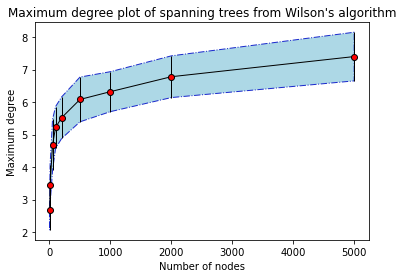

   nodes  average maximum degree  standard deviation
0      5                    2.68            0.614492
1     10                    3.46            0.606960
2     50                    4.68            0.785875
3    100                    5.22            0.641561
4    200                    5.52            0.640000
5    500                    6.08            0.688186
6   1000                    6.32            0.614492
7   2000                    6.78            0.641561
8   5000                    7.40            0.748331


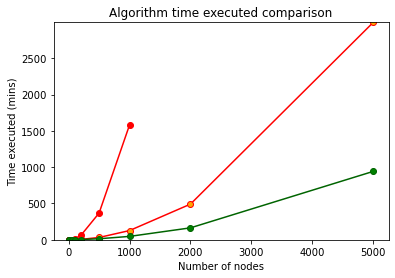

In [172]:
# Line plots of maximum degree
fig, ax = plt.subplots()

x = [5,10,50,100,200,500,1000,2000,5000]
y = avg_max_deg
err = std_list
ax.errorbar(x, y, yerr = err, marker="o", linewidth=1, mfc="red", color="black")
plt.fill_between(x, np.array(y) - np.array(err), np.array(y) + np.array(err), edgecolor='#1B2ACC', linestyle='dashdot'
                , facecolor = "lightblue")
plt.title("Maximum degree plot of spanning trees from Wilson's algorithm")
plt.xlabel("Number of nodes")
plt.ylabel("Maximum degree")
plt.yticks(np.arange(math.floor(min(y)), max(y)+1, 1))
#for x,y in zip(x, y):   
#    plt.annotate("{:.2f}".format(y), (x,y), textcoords="offset points", xytext=(1,10), ha='center')
plt.show()

# Result table
data = {"nodes": [5,10,50,100,200,500,1000,2000,5000], "average maximum degree": avg_max_deg, "standard deviation": std_list}
max_deg_df = pd.DataFrame(data)
print(max_deg_df)

# Execution time analysis

fig2, ax2 = plt.subplots()
ax2.plot([5,10,50,100,200,500,1000,2000,5000], np.array(prevv_code_time), marker = "o", mfc = "red", color = "red")
ax2.plot([5,10,50,100,200,500,1000,2000,5000], np.array(prev_code_time), marker = "o", mfc = "orange", color = "red")
ax2.plot([5,10,50,100,200,500,1000,2000,5000], np.array([4.42, 8.78, 43.7, 94.4, 229.26, 868.35, 2810.7,  9874.98, 56519.22])/60, marker = "o", mfc = "green", color = "darkgreen")
plt.xlabel("Number of nodes")
plt.ylabel("Time executed (mins)")
plt.ylim([0, prev_code_time.max()])
plt.title("Algorithm time executed comparison")
plt.show()

In [141]:
result

[{None: (2.68, 0.6144916598294887)},
 {None: (3.46, 0.6069596362197407)},
 {None: (4.68, 0.7858753081755401)},
 {None: (5.22, 0.6415605972938176)},
 {None: (5.52, 0.64)},
 {None: (6.08, 0.6881860213634101)},
 {None: (6.32, 0.6144916598294887)},
 {None: (6.78, 0.6415605972938176)},
 {None: (7.4, 0.7483314773547882)}]